# CS 584 Assignment 4 -- Sequence to Sequence Models

#### Name: (Zhiyao Wen)

## In this assignment, you are required to follow the steps below:
1. Review the lecture slides.
2. Implement a Seq2Seq model.

*** Please note that there are many online resources for Seq2Seq models, you are allowed to check them, but DO NOT DIRECTLY COPY from them. Otherwise, you will get ZERO for this assignment. ***

In [2]:
# !pip install numpy scikit-learn tqdm matplotlib
# !pip install -U spacy
# !python -m spacy download en_core_web_sm
# !python -m spacy download es_core_news_sm

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 11.3/11.3 MB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 2.4 MB/s eta 0:00:00
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/21/6d/ed44cb52e8d0f7933c93cb6d590c1b148e8fa44fce08a156e726947c4546/srsly-2.4.2-cp39-cp39-win_amd64.whl (451 kB)
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.5
    Uninstalling thinc-7.4.5:
      Successfully uninstalled thinc-7.4.5
  Attempting uninstall: spacy
    Found existing installation: spacy 2.3.5
    Uninstallin

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 2.3.1 requires spacy<2.4.0,>=2.3.0, but you have spacy 3.2.4 which is incompatible.
Traceback (most recent call last):
  File "C:\Users\10617\anaconda3\lib\site-packages\urllib3\connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "C:\Users\10617\anaconda3\lib\site-packages\urllib3\util\connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "C:\Users\10617\anaconda3\lib\socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11004] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\10617\anaconda3\lib\site-packages\urllib3\con

  File "C:\Users\10617\anaconda3\lib\site-packages\click\core.py", line 1128, in __call__
    return self.main(*args, **kwargs)
  File "C:\Users\10617\anaconda3\lib\site-packages\click\core.py", line 1053, in main
    rv = self.invoke(ctx)
  File "C:\Users\10617\anaconda3\lib\site-packages\click\core.py", line 1659, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "C:\Users\10617\anaconda3\lib\site-packages\click\core.py", line 1395, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "C:\Users\10617\anaconda3\lib\site-packages\click\core.py", line 754, in invoke
    return __callback(*args, **kwargs)
  File "C:\Users\10617\anaconda3\lib\site-packages\typer\main.py", line 500, in wrapper
    return callback(**use_params)  # type: ignore
  File "C:\Users\10617\anaconda3\lib\site-packages\spacy\cli\download.py", line 35, in download_cli
    download(model, direct, sdist, *ctx.args)
  File "C:\Users\10617\anaconda3\lib\site-packages\spacy\cli\do

# 1. Data Process
In this section, you are required to 
1. Divide the data into train, validation, and test.
2. Preprocess the text data

**Note:** The default dataset is for Spanish-English. Feel free to change other pairs of languages, you can find them [here](http://www.statmt.org/europarl/).

In [1]:
import numpy as np
from tqdm.notebook import tqdm

def load_data(filepath):
    texts = []
    with open(filepath, 'r', encoding='utf-8') as f:
        count = len(f.readlines())
        
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in tqdm(f, total=count):
            texts.append(line.strip())
            
    return np.array(texts[:20000])

sources = load_data('content/europarl-v7.es-en.en')
targets = load_data('content/europarl-v7.es-en.es')

print('Englist sentences size:', sources.shape)
print('Spanish sentences size:', targets.shape)

  0%|          | 0/1965734 [00:00<?, ?it/s]

  0%|          | 0/1965734 [00:00<?, ?it/s]

Englist sentences size: (20000,)
Spanish sentences size: (20000,)


## 1.1 Divide the data into train, validation, and test

In [31]:
from sklearn.model_selection import train_test_split

source_train, source_test, target_train, target_test = train_test_split(sources, targets, test_size=0.2)
source_train, source_valid, target_train, target_valid = train_test_split(source_train, target_train, test_size=0.2)

train_texts = [(sent_source, sent_target) for sent_source, sent_target in zip(source_train, target_train)]
valid_texts = [(sent_source, sent_target) for sent_source, sent_target in zip(source_valid, target_valid)]
test_texts = [(sent_source, sent_target) for sent_source, sent_target in zip(source_test, target_test)]

print('The size of training set:', len(train_texts))
print('The size of valid set:', len(valid_texts))
print('The size of test set:', len(test_texts))

The size of training set: 12800
The size of valid set: 3200
The size of test set: 4000


## 1.2 Data preprocessing
1. Lowercase the text
2. Tokenize the text
3. Create vocabulary for the source language and target language, respectively.

In [3]:
import re
import string
import spacy
from itertools import chain
from unicodedata import normalize, category
import en_core_web_sm


nlp_en = en_core_web_sm.load() # change the method
nlp_es = en_core_web_sm.load()


def tokenize_en(text):
    # text = re.sub(r'’', '\'', text) # some of texts contain invalid apostrophes, such as ’
    # text = normalize('NFD', text).encode('ascii', 'ignore').decode('UTF-8')
    # text = re.sub(r'([.!.?])', r' \1', text)
    # text = re.sub(r'[^a-zA-Z-]', r' ', text)
    # tokens = text.lower().strip().split()
    doc = nlp_en(text.lower())
    return [token.text for token in doc]
    # return tokens

def tokenize_es(text):
    doc = nlp_es(text.lower())
    return [token.text for token in doc]

def preprocess(texts, type='en'):
    if type == 'en':
        return [tokenize_en(text) for text in tqdm(texts, desc='en')]
    elif type == 'es':
        return [tokenize_es(text) for text in tqdm(texts, desc='es')]

def generate_vocab(tokenized_texts):
    # Flatten the input to 1d array, Thanks for: 
    # https://stackoverflow.com/questions/29244286/how-to-flatten-a-2d-list-to-1d-without-using-numpy
    vocab = list(chain.from_iterable(tokenized_texts))
    return list(set(vocab))

source_tokens = preprocess(source_train, 'en')
target_tokens = preprocess(target_train, 'es')

source_vocab = generate_vocab(source_tokens)
source_vocab.insert(0, '<unk>')
source_token2idx = {token: idx for idx, token in enumerate(source_vocab)}

target_vocab = generate_vocab(target_tokens)
target_vocab.insert(0, '<end>')
target_vocab.insert(0, '<start>')
target_vocab.insert(0, '<unk>')
target_token2idx = {token: idx for idx, token in enumerate(target_vocab)}

print('English vocab size:', len(source_vocab))
print('Spanish vocab size:', len(target_vocab))

en:   0%|          | 0/12800 [00:00<?, ?it/s]

es:   0%|          | 0/12800 [00:00<?, ?it/s]

English vocab size: 12472
Spanish vocab size: 19708


In [5]:
train_set = [([source_token2idx[t] for t in tokenize_en(source)], [target_token2idx[t] for t in tokenize_es(target)]) for source, target in train_texts]
valid_set = [([source_token2idx[t] if t in source_token2idx else 0 for t in tokenize_en(source)], [target_token2idx[t] if t in target_token2idx else 0 for t in tokenize_es(target)]) for source, target in valid_texts]
test_set = [([source_token2idx[t] if t in source_token2idx else 0 for t in tokenize_en(source)], [target_token2idx[t] if t in target_token2idx else 0 for t in tokenize_es(target)]) for source, target in test_texts]


In [2]:
# #max length in input_texts and target_texts
# max_encoder_seq_length = max(len(line) for line in sources)
# max_decoder_seq_length = max(len(line) for line in targets)

# set to 150, cause the origin sentence length is too larger and the model can not be fitted
max_encoder_seq_length = 150
max_decoder_seq_length = 150

print('max length of input  sentences: %d' % (max_encoder_seq_length))
print('max length of target sentences: %d' % (max_decoder_seq_length))

max length of input  sentences: 150
max length of target sentences: 150


In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# encode and pad sequences
def text2sequences(max_len, lines):
    tokenizer = Tokenizer(char_level=True, filters='')
    tokenizer.fit_on_texts(lines)
    seqs = tokenizer.texts_to_sequences(lines)
    seqs_pad = pad_sequences(seqs, maxlen=max_len, padding='post')
    return seqs_pad, tokenizer.word_index


# convert to matrix
# numbers of sentence x max length of input sentences
encoder_input_seq, input_token_index = text2sequences(max_encoder_seq_length, 
                                                      sources)
decoder_input_seq, target_token_index = text2sequences(max_decoder_seq_length, 
                                                       targets)

print('shape of encoder_input_seq: ' + str(encoder_input_seq.shape))
print('shape of input_token_index: ' + str(len(input_token_index)))
print('shape of decoder_input_seq: ' + str(decoder_input_seq.shape))
print('shape of target_token_index: ' + str(len(target_token_index)))

shape of encoder_input_seq: (20000, 150)
shape of input_token_index: 79
shape of decoder_input_seq: (20000, 150)
shape of target_token_index: 79


In [4]:
num_encoder_tokens = len(input_token_index) + 1
num_decoder_tokens = len(target_token_index) + 1

print('num_encoder_tokens: ' + str(num_encoder_tokens))
print('num_decoder_tokens: ' + str(num_decoder_tokens))

num_encoder_tokens: 80
num_decoder_tokens: 80


In [5]:
from tensorflow.keras.utils import to_categorical
import numpy

# one hot encode target sequence
def onehot_encode(sequences, max_len, vocab_size):
    n = len(sequences)
    data = numpy.zeros((n, max_len, vocab_size))
    for i in range(n):
        data[i, :, :] = to_categorical(sequences[i], num_classes=vocab_size)
    return data

encoder_input_data = onehot_encode(encoder_input_seq, max_encoder_seq_length, num_encoder_tokens)
decoder_input_data = onehot_encode(decoder_input_seq, max_decoder_seq_length, num_decoder_tokens)

decoder_target_seq = numpy.zeros(decoder_input_seq.shape)
decoder_target_seq[:, 0:-1] = decoder_input_seq[:, 1:]
decoder_target_data = onehot_encode(decoder_target_seq, 
                                    max_decoder_seq_length, 
                                    num_decoder_tokens)

print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(20000, 150, 80)
(20000, 150, 80)
(20000, 150, 80)


## 2. Seq2Seq Model (50 points)
In this section, you are required to 
1. Implement a seq2seq model which includes a CNN encoder and an RNN based decoder.  
2. For each RNN cell, try a simple RNN, LSTM, and GRU.  
3. Use the validation set to compute the BLEU score and report the best choice.

**Note:** you could use any package you are comfortable with, such as PyTorch and TensorFlow.

### 2.1 Encoder (25 points)

Try a simple RNN, LSTM, and GRU

In [7]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from keras.layers import Concatenate,Bidirectional

latent_dim = 300

class Encoder:
    def __init__(self,num_encoder_tokens, latent_dim = latent_dim):
        self.num_encoder_tokens = num_encoder_tokens
        
    
    def encoder_model(self, state_h, state_c):
        # build the encoder network model
        encoder_model = Model(inputs=encoder_inputs, 
                          outputs=[state_h, state_c],
                          name='encoder')
        return encoder_model
    
    def encoder_LSTM():
        # inputs of the encoder network
        encoder_inputs = Input(shape=(None, self.num_encoder_tokens), 
                           name='encoder_inputs')
        
        # set the LSTM layer
        encoder_lstm = LSTM(latent_dim, return_state=True, 
                        dropout=0.5, name='encoder_lstm')
        _, state_h, state_c = encoder_lstm(encoder_inputs)

        encoder_LSTM = encoder_model(state_h, state_c)
        
        return encoder_LSTM
    
    def encoder_GRU():
        # inputs of the encoder network
        encoder_inputs = Input(shape=(None, self.num_encoder_tokens), 
                           name='encoder_inputs')

        # set the GRU layer
        encoder_GRU = GRU(latent_dim, return_state=True, 
                        dropout=0.5, name='encoder_GRU')
        _, state_h, state_c = encoder_GRU(encoder_inputs)

        encoder_GRU = encoder_model(state_h, state_c)
        
        return encoder_GRU
        
    
    def encoder_BiLSTM(self,model):
        # inputs of the encoder network
        encoder_inputs = Input(shape=(None, self.num_encoder_tokens), 
                           name='encoder_inputs')

        # set the BiLSTM layer
        encoder_BiLSTM = Bidirectional(LSTM(latent_dim, return_state=True, 
                                      dropout=0.5, name='encoder_bilstm'))
        _, forward_h, forward_c, backward_h, backward_c = encoder_BiLSTM(encoder_inputs)

        state_h = Concatenate()([forward_h, backward_h])
        state_c = Concatenate()([forward_c, backward_c])
        
        encoder_BiLSTM = encoder_model(state_h, state_c)
        
        return encoder_BiLSTM

### 2.2 CNN Encoder (Extra Credit)

A traditional encoder of Seq2Seq models is an RNN-based model, such as RNN, LSTM, or GRU. But CNNs can also be encoders. In this sub-section, you need to implement a CNN encoder for your Seq2Seq model.

**Hint:** We already learned how CNN can be applied to sentence classification tasks. You can simply drop the last layer of TextCNN and output the context vector. Please check this [paper](https://arxiv.org/abs/1510.03820) for details.

### 2.3 Decoder (25 points)
Try a simple RNN, LSTM, and GRU

In [8]:
class Decoder:
    
    def __init__(self, num_decoder_tokens,latent_dim = latent_dim):
        self.num_decoder_tokens = num_decoder_tokens
    
    def decoder_inputs(inputs):
        # inputs of the decoder network
        decoder_input_h = Input(shape=(latent_dim,), name='decoder_input_h') 
        decoder_input_c = Input(shape=(latent_dim,), name='decoder_input_c')
        decoder_input_x = Input(shape=(None, self.num_decoder_tokens), name='decoder_input_x')
        input_dic = {"input_h":decoder_input_h,
                    "input_c":decoder_input_c,
                    "input_x":decoder_input_x}
        
        return input_dic[inputs]
    
    def decoder_outputs(self,decoder_modele_outputs):
        # set the dense layer
        decoder_dense = Dense(self.num_decoder_tokens, activation='softmax', name='decoder_dense')
        decoder_outputs = decoder_dense(decoder_modele_outputs)
        return decoder_outputs
    
    def decoder_LSTM():

        # set the LSTM layer
        decoder_lstm = LSTM(latent_dim, return_sequences=True, 
                            return_state=True, dropout=0.5, name='decoder_lstm')
        decoder_lstm_outputs, state_h, state_c = decoder_lstm(decoder_inputs(input_x), 
                                                              initial_state=[decoder_inputs(input_h), decoder_inputs(input_c)])
        
        decoder_outputs = decoder_outputs(decoder_lstm_outputs)

        # build the decoder network model
        decoder_model = Model(inputs=[decoder_input_x, decoder_input_h, decoder_input_c],
                              outputs=[decoder_outputs, state_h, state_c],
                              name='decoder')
        return decoder_model

    def decoder_GRU():
        
        # set the LSTM layer
        decoder_GRU = LSTM(latent_dim, return_sequences=True, 
                            return_state=True, dropout=0.5, name='decoder_GRU')
        decoder_GRU_outputs, state_h, state_c = decoder_GRU(decoder_inputs(input_x), 
                                                              initial_state=[decoder_inputs(input_h), decoder_inputs(input_c)])

        decoder_outputs = decoder_outputs(decoder_GRU_outputs)

        # build the decoder network model
        decoder_model = Model(inputs=[decoder_input_x, decoder_input_h, decoder_input_c],
                              outputs=[decoder_outputs, state_h, state_c],
                              name='decoder')
        return decoder_model
    
    def decoder_BiLSTM():

        # set the LSTM layer
        decoder_Bilstm = LSTM(latent_dim * 2, return_sequences=True,   # laten_dim times 2
                            return_state=True, dropout=0.5, name='decoder_lstm')
        decoder_Bilstm_outputs, state_h, state_c = decoder_Bilstm(decoder_inputs(input_x), 
                                                              initial_state=[decoder_inputs(input_h), decoder_inputs(input_c)])

        decoder_outputs = decoder_outputs(decoder_Bilstm_outputs)

        # build the decoder network model
        decoder_model = Model(inputs=[decoder_input_x, decoder_input_h, decoder_input_c],
                              outputs=[decoder_outputs, state_h, state_c],
                              name='decoder')
        return decoder_model

In [9]:
# The decoder and encoder might have some problem, so I just list one type of encoder and decoder here
latent_dim = 256

encoder_inputs = Input(shape=(None, num_encoder_tokens), 
                       name='encoder_inputs')

encoder_bilstm = Bidirectional(LSTM(latent_dim, return_state=True, 
                                  dropout=0.5, name='encoder_lstm'))
_, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(encoder_inputs)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c]) # stacking RNN

# build the encoder network model
encoder_model = Model(inputs=encoder_inputs, 
                      outputs=[state_h, state_c],
                      name='encoder')

# inputs of the decoder network
decoder_input_h = Input(shape=(latent_dim * 2,), name='decoder_input_h') # laten_dim times 2
decoder_input_c = Input(shape=(latent_dim * 2,), name='decoder_input_c') # laten_dim times 2
decoder_input_x = Input(shape=(None, num_decoder_tokens), name='decoder_input_x')

# set the LSTM layer
decoder_lstm = LSTM(latent_dim * 2, return_sequences=True,   # laten_dim times 2
                    return_state=True, dropout=0.5, name='decoder_lstm')
decoder_lstm_outputs, state_h, state_c = decoder_lstm(decoder_input_x, 
                                                      initial_state=[decoder_input_h, decoder_input_c])

# set the dense layer
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_lstm_outputs)

# build the decoder network model
decoder_model = Model(inputs=[decoder_input_x, decoder_input_h, decoder_input_c],
                      outputs=[decoder_outputs, state_h, state_c],
                      name='decoder')

# model concatenation
# input layers
encoder_input_x = Input(shape=(None, num_encoder_tokens), name='encoder_input_x')
decoder_input_x = Input(shape=(None, num_decoder_tokens), name='decoder_input_x')

# connect encoder to decoder
encoder_final_states = encoder_model([encoder_input_x])
decoder_output, _, _ = decoder_lstm(decoder_input_x, initial_state=encoder_final_states)
decoder_pred = decoder_dense(decoder_output)

model = Model(inputs=[encoder_input_x, decoder_input_x], 
              outputs=decoder_pred, 
              name='model_training')


## 3. Training your Seq2Seq (30 points)
1. Implement training process
2. Use validation set to calculate BLEU score
3. Plot your training loss and validation loss (You could use the code in assignment 1)

In [10]:
import os
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

learning_rate = 1E-4
epochs = 200
batch_size = 64

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', patience=5, verbose=2)

history = model.fit([encoder_input_data, decoder_input_data],  
          decoder_target_data,                        
          validation_split=0.2,                      # validation split
                                                    # I do not follow the example code that be provided, I split the valid dataset here with pramater
          batch_size = batch_size,
          epochs = epochs,
          callbacks = [early_stopping] )


Epoch 1/200
250/250 [==============================] - 18s 50ms/step - loss: 2.3765 - acc: 0.3410 - val_loss: 1.9176 - val_acc: 0.4506
Epoch 2/200
250/250 [==============================] - 11s 46ms/step - loss: 1.9470 - acc: 0.4226 - val_loss: 1.7022 - val_acc: 0.4955
Epoch 3/200
250/250 [==============================] - 11s 45ms/step - loss: 1.8342 - acc: 0.4501 - val_loss: 1.5448 - val_acc: 0.5365
Epoch 4/200
250/250 [==============================] - 11s 46ms/step - loss: 1.7594 - acc: 0.4725 - val_loss: 1.4417 - val_acc: 0.5720
Epoch 5/200
250/250 [==============================] - 13s 52ms/step - loss: 1.6985 - acc: 0.4915 - val_loss: 1.3628 - val_acc: 0.5961
Epoch 6/200
250/250 [==============================] - 12s 47ms/step - loss: 1.6547 - acc: 0.5049 - val_loss: 1.3078 - val_acc: 0.6122
Epoch 7/200
250/250 [==============================] - 12s 48ms/step - loss: 1.6203 - acc: 0.5152 - val_loss: 1.2637 - val_acc: 0.6242
Epoch 8/200
250/250 [==============================] - 

250/250 [==============================] - 13s 54ms/step - loss: 1.3400 - acc: 0.5941 - val_loss: 0.9375 - val_acc: 0.7154
Epoch 62/200
250/250 [==============================] - 13s 54ms/step - loss: 1.3384 - acc: 0.5946 - val_loss: 0.9374 - val_acc: 0.7150
Epoch 63/200
250/250 [==============================] - 13s 54ms/step - loss: 1.3387 - acc: 0.5948 - val_loss: 0.9378 - val_acc: 0.7144
Epoch 64/200
250/250 [==============================] - 13s 54ms/step - loss: 1.3343 - acc: 0.5959 - val_loss: 0.9363 - val_acc: 0.7159
Epoch 65/200
250/250 [==============================] - 13s 54ms/step - loss: 1.3358 - acc: 0.5956 - val_loss: 0.9394 - val_acc: 0.7147
Epoch 66/200
250/250 [==============================] - 13s 54ms/step - loss: 1.3340 - acc: 0.5963 - val_loss: 0.9352 - val_acc: 0.7154
Epoch 67/200
250/250 [==============================] - 13s 53ms/step - loss: 1.3320 - acc: 0.5963 - val_loss: 0.9273 - val_acc: 0.7177
Epoch 68/200
250/250 [==============================] - 13s 5

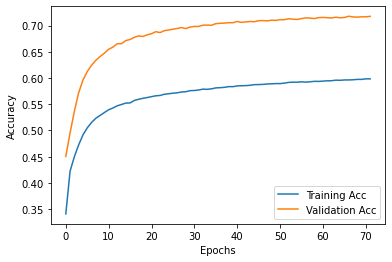

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(range(len(acc)), acc, label='Training Acc')
plt.plot(range(len(acc)), val_acc, label='Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 4. Evaluation (20 points)
1. Calculate the BLEU scores of the best seq2seq model obtained from section 2&3 on the test set.
2. Select 20 test examples, For each example, print the translation result of your model along with the ground truth

### 4.1 Calculate the BLEU score on test set. (10 points)

In [15]:
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm_notebook

def bleu_score(original_text, translation):
    
    score = sentence_bleu([str(original_text).split()], str(translation).split())
    return score


scores_list = []
sentence_idx = 0


for sentence in tqdm_notebook(train_texts):
    
    input_sequence = []
    
    for token in sentence:
        # build input_sequence
        input_sequence.append(input_token_index[token])
    
    input_sequence = [input_sequence]
    
    #convert to sequence matix
    input_sequence = np.array(input_sequence).reshape(1, len(input_sequence[0])) 
    seqs_pad = pad_sequences(input_sequence, maxlen=max_encoder_seq_length, padding='post')
    #one-hot
    train_texts = onehot_encode(seqs_pad, max_encoder_seq_length, num_encoder_tokens) 
    
    translated_sentence = decode_sequence(train_texts)

    score = bleu_score(test_texts[sentence_idx], train_texts)  # compared with each test target
    sentence_idx += 1
    scores_list.append(score)
    print("Spanish:" + train_texts)
    print()
    print("Translation from seq2seq model:" + translated_sentence)
print("The bleu scores is:", numpy.mean(scores_list))

C:\Users\10617\AppData\Local\Temp/ipykernel_3552/2027942406.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sentence in tqdm_notebook(train_texts):


  0%|          | 0/12800 [00:00<?, ?it/s]

KeyError: 'Five amendments have been presented by Parliament.'

### 4.2 Translate 20 test exmaples. (10 points)

In [16]:
# Reverse-lookup token index to decode sequences back to something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


In [17]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = numpy.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # this line of code is greedy selection
        # try to use multinomial sampling instead (with temperature)
        sampled_token_index = numpy.argmax(output_tokens[0, -1, :])
        
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        target_seq = numpy.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence

In [ ]:
for seq_index in range(2100, 2120):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('English:       ', input_texts[seq_index])
    print('Spanish (true): ', target_texts[seq_index][1:-1])
    print('Spanish (pred): ', decoded_sentence[0:-1])